<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/FinLough_imageMERGE%26CROP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#unzip
!unzip -q "/content/drive/MyDrive/finlough.zip" -d "/content/dataset"

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
im1 = '/content/dataset/finlough/finlough_ortho-0-0.tif'
im2 = '/content/dataset/finlough/finlough_ortho-0-1.tif'
im3 = '/content/dataset/finlough/finlough_ortho-1-0.tif'
im4 = '/content/dataset/finlough/finlough_ortho-1-1.tif'

In [1]:
from osgeo import gdal

# Define your input paths
input_images = [
    '/content/dataset/finlough/finlough_ortho-0-0.tif',
    '/content/dataset/finlough/finlough_ortho-0-1.tif',
    '/content/dataset/finlough/finlough_ortho-1-0.tif',
    '/content/dataset/finlough/finlough_ortho-1-1.tif'
]
output_path = '/content/dataset/finlough/finlough_ortho_merged.tif'

# 1. Build a Virtual Raster (VRT)
# This just creates a reference file, using virtually no RAM.
vrt = gdal.BuildVRT('/content/temp.vrt', input_images)

# 2. Write the VRT to a real GeoTIFF on disk
# 'COMPRESS=LZW' significantly reduces output file size.
# 'TILED=YES' improves performance for large geographic images.
gdal.Translate(output_path, vrt, creationOptions=['COMPRESS=LZW', 'TILED=YES'])

# Clean up variables to free memory
vrt = None
print(f"Successfully merged to: {output_path}")


/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Successfully merged to: /content/dataset/finlough/finlough_ortho_merged.tif


In [2]:
input_dsms = [
    '/content/dataset/finlough/finlough_dem-0-0.tif',
    '/content/dataset/finlough/finlough_dem-0-1.tif',
    '/content/dataset/finlough/finlough_dem-1-0.tif',  # Corrected from your list
    '/content/dataset/finlough/finlough_dem-1-1.tif'
]
output_dsm_path = '/content/dataset/finlough/finlough_dem_merged.tif'

# 1. Build the Virtual Raster
vrt = gdal.BuildVRT('/content/temp_dsm.vrt', input_dsms)

# 2. Translate to final GeoTIFF
# Use PREDICTOR=3 for floating point elevation data (DSM/DEM)
gdal.Translate(output_dsm_path, vrt, creationOptions=[
    'COMPRESS=LZW',
    'PREDICTOR=3',
    'TILED=YES'
])

vrt = None
print(f"DSM Merge complete: {output_dsm_path}")

DSM Merge complete: /content/dataset/finlough/finlough_dem_merged.tif


In [4]:
from osgeo import gdal

# Path to your existing NDVI file
ndvi_path = '/content/dataset/finlough/Finlough_Summer_NDVI.tif'

# Open NDVI to get its coordinates
ndvi_ds = gdal.Open(ndvi_path)
geo_t = ndvi_ds.GetGeoTransform()

# Calculate bounding box: [minX, maxY, maxX, minY]
min_x = geo_t[0]
max_y = geo_t[3]
max_x = min_x + geo_t[1] * ndvi_ds.RasterXSize
min_y = max_y + geo_t[5] * ndvi_ds.RasterYSize

ndvi_ds = None # Close file


In [5]:
# Choose which merged image to crop
merged_input = '/content/dataset/finlough/finlough_ortho_merged.tif'
cropped_output = '/content/dataset/finlough/finlough_ortho_cropped_to_ndvi.tif'

# Perform the crop using the bounding box from Step 1
gdal.Translate(
    cropped_output,
    merged_input,
    projWin=[min_x, max_y, max_x, min_y],
    creationOptions=['COMPRESS=LZW', 'TILED=YES']
)

print(f"Cropped image saved: {cropped_output}")


Cropped image saved: /content/dataset/finlough/finlough_ortho_cropped_to_ndvi.tif


In [6]:

# Choose which merged image to crop
merged_input = '/content/dataset/finlough/finlough_dem_merged.tif'
cropped_output = '/content/dataset/finlough/finlough_dem_cropped_to_ndvi.tif'

# Perform the crop using the bounding box from Step 1
gdal.Translate(
    cropped_output,
    merged_input,
    projWin=[min_x, max_y, max_x, min_y],
    creationOptions=['COMPRESS=LZW', 'TILED=YES']
)

print(f"Cropped image saved: {cropped_output}")

Cropped image saved: /content/dataset/finlough/finlough_dem_cropped_to_ndvi.tif


In [9]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
S_RGB_PATH = '/content/dataset/finlough/finlough_ortho_cropped_to_ndvi.tif'
S_NDVI_PATH = '/content/dataset/finlough/Finlough_Summer_NDVI.tif'
S_DSM = '/content/dataset/finlough/finlough_dem_cropped_to_ndvi.tif'

SHP_PATH = '/content/dataset/finlough/finlough_habi.shp'

In [10]:
import rasterio

# Check CRS of all files
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_DSM) as sd:
    print(f"Summer RGB CRS: {sr.crs}")
    print(f"Summer DSM CRS: {sd.crs}")
    gdf = gpd.read_file(SHP_PATH)
    print(f"Shapefile CRS:  {gdf.crs}")

# If they don't match, we must reproject the Shapefile to match the Raster
gdf = gdf.to_crs(sr.crs)

Summer RGB CRS: EPSG:2157
Summer DSM CRS: EPSG:2157
Shapefile CRS:  EPSG:2157


In [11]:
print(gdf.columns)

Index(['fid', 'FEN_ID', 'FEN_NAME', 'SITECODE', 'AREA_m2', 'NOTES_PRE',
       'NOTES_POST', 'SURVEYOR', 'NON_HDH', '7140', '7210', '7230', '3180',
       '4010', '6211', '6410', '6430', '7110', '7130', '91D0', '91E0',
       'PCENT_HDH', 'ED2', 'ED3', 'FL3', 'FL6', 'FL8', 'FS1', 'FS2', 'FW2',
       'FW4', 'GA1', 'GM1', 'GS1', 'GS2', 'GS4', 'HD1', 'HH3', 'PB1', 'PB4',
       'PF1', 'PF2', 'PF3', 'WD1', 'WD2', 'WD3', 'WD4', 'WL1', 'WL2', 'WN2',
       'WN6', 'WN7', 'WS1', 'NON_HDH_PF', 'HDH_MAPPED', 'HCH_MAPPED', 'FE1',
       'FE1A', 'FE1B', 'FE2', 'FE2A', 'FE2C', 'FE2D', 'FE2F', 'FE3', 'FE3A',
       'FE3B', 'FE3D', 'FW3', 'FW3C', 'FW3G', 'FW3H', 'GL1', 'GL1D', 'HE4C',
       'HE4D', 'JUNC_SUBNO', 'geometry'],
      dtype='object')


In [12]:

LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)


In [13]:
print(gdf[NAME_COL].unique())

['PB4' 'GS1' 'WS1' 'HH3' 'WN7' 'FS1' 'PF1' 'WN6' 'FS2' 'PF3' 'PF3/FS1'
 'FL3']


In [14]:
fossitt_merger = {
    # Peatlands (P)
    'PF1': 'Peatlands',
    'PF3': 'Peatlands',
    'PF3/FS1': 'Peatlands',
    'PB4': 'Peatlands',

    # Grasslands (G)
    'GS1': 'Grasslands',

    # Woodland & Scrub (W)
    'WS1': 'Woodland_Scrub',
    'WN6': 'Woodland_Scrub',
    'WN7': 'Woodland_Scrub',
    'HH3': 'Woodland_Scrub',

    #wet
    'FS1': 'Wet',
    'FS2': 'Wet',
    'FL3': 'Wet',
}

gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [16]:
all_pixels, all_labels = [], []

# --- 2. COORDINATED EXTRACTION ---
# Open all 4 sources (Note: W_RGB_PATH and W_NDVI_PATH are not defined and need to be added to the with statement if 4 sources are desired)
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn:
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    print("Extracting features...")
    for idx, row in gdf.iterrows():
        try:
            poly = row.geometry
            min_x, min_y, max_x, max_y = poly.bounds
            points = []
            for _ in range(1000):
                pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
                if Point(pt).within(poly): points.append(pt)
                if len(points) >= 300: break

            if not points: continue

            # Sample all 4 rasters (Currently only summer rasters are sampled due to missing winter raster definitions)
            s_rgb_vals = np.array(list(sr.sample(points))).astype('float32')
            s_ndvi_vals = np.array(list(sn.sample(points))).astype('float32')


            # Feature Engineering
            # 1-6: Summer RGB + Winter RGB
            # 7-8: Summer NDVI + Winter NDVI
            # 9-10: Summer VARI + Winter VARI (Calculated from RGB)
            s_vari = (s_rgb_vals[:,1]-s_rgb_vals[:,0]) / (s_rgb_vals[:,1]+s_rgb_vals[:,0]-s_rgb_vals[:,2]+1e-5)


            combined = np.column_stack([
                s_rgb_vals, # w_rgb_vals would be undefined
                s_ndvi_vals, # w_ndvi_vals would be undefined
                s_vari # w_vari and delta_ndvi would be undefined
            ])

            valid = np.any(s_rgb_vals > 0, axis=1)
            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))
        except: continue

X, y = np.vstack(all_pixels), np.array(all_labels)

Extracting features...


In [17]:
print(f"Total training samples: {len(X)}")

Total training samples: 12455


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report ---")
print(classification_report(y_test, rf.predict(X_test)))



--- Final Multi-Source Seasonal Report ---
                precision    recall  f1-score   support

    Grasslands       0.83      0.81      0.82       133
     Peatlands       0.41      0.22      0.29       903
           Wet       0.40      0.28      0.33       805
Woodland_Scrub       0.60      0.81      0.69      1896

      accuracy                           0.55      3737
     macro avg       0.56      0.53      0.53      3737
  weighted avg       0.52      0.55      0.52      3737



In [19]:
import numpy as np
from scipy import ndimage

In [20]:
def get_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    for _ in range(num_points * 3): # 3x attempts to find points within poly
        pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if Point(pt).within(poly):
            points.append(pt)
        if len(points) >= num_points:
            break
    return points

In [21]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    print("Extracting 6 Summer Features...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 300)
        if not pts: continue

        # Sample summer rasters at point locations
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)

        # Combine into 6-column stack
        combined = np.column_stack([
            s_rgb,           # 1-3: Summer RGB
            s_nd,            # 4: Summer NDVI
            s_vari,          # 5: Summer VARI
            s_h              # 6: Summer Height (DSM)
        ])

        # Filter: Ensure Summer RGB is not black
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        num_valid = valid_pixels.shape[0]

        if num_valid > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * num_valid)

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Final Data Sync: X={X.shape}, y={y.shape}")

Extracting 6 Summer Features...
Final Data Sync: X=(12243, 6), y=(12243,)


In [22]:
print(f"Total training samples: {len(X)}")

Total training samples: 12243



--- Final Multi-Source Seasonal Report (Summer Features Only) ---
                precision    recall  f1-score   support

    Grasslands       0.84      0.84      0.84       122
     Peatlands       0.57      0.45      0.50       865
           Wet       0.52      0.44      0.48       797
Woodland_Scrub       0.73      0.84      0.78      1889

      accuracy                           0.66      3673
     macro avg       0.67      0.64      0.65      3673
  weighted avg       0.65      0.66      0.65      3673



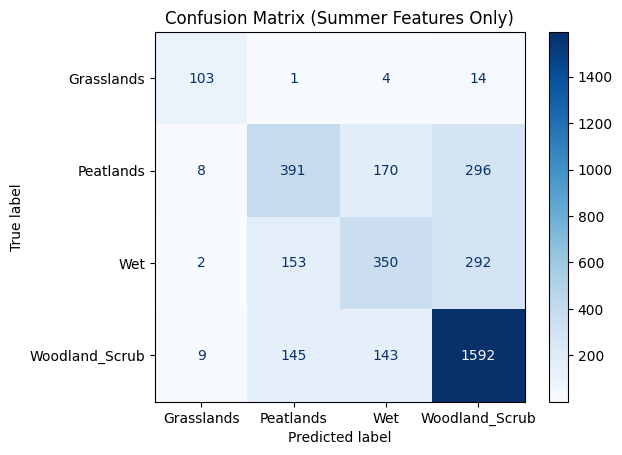

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report (Summer Features Only) ---")
print(classification_report(y_test, rf.predict(X_test)))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf.predict(X_test), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Summer Features Only)')
plt.show()

In [25]:
def calculate_local_slope(window, res):
    """Calculates the maximum slope from a 3x3 window of elevation data."""
    if window.shape != (3, 3):
        return 0.0
    # Sobel-like filters for horizontal and vertical gradients
    dz_dx = ((window[0, 2] + 2 * window[1, 2] + window[2, 2]) -
             (window[0, 0] + 2 * window[1, 0] + window[2, 0])) / (8 * res)
    dz_dy = ((window[2, 0] + 2 * window[2, 1] + window[2, 2]) -
             (window[0, 0] + 2 * window[0, 1] + window[0, 2])) / (8 * res)
    slope = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2)) * (180 / np.pi)
    return slope

In [27]:
all_pixels, all_labels = [], []

# Using only Summer paths since Winter data is unavailable
with rasterio.open(S_RGB_PATH) as sr, \
     rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd:

    RES = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)

    # Map the labels (Using your column name 'FossittCod' from previous cells)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 16 Features (Summer Spectral + Height + Slope + Advanced Indices)...")

    for idx, row in gdf.iterrows():
        # Get random points within the polygon
        pts = get_random_points(row.geometry, 300)
        if not pts: continue

        # 1. Base Sampling (Summer Only)
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()

        # 2. Slope Sampling
        s_slopes = []
        for pt in pts:
            r_idx, c_idx = sd.index(pt[0], pt[1])
            # Define a 3x3 window around the point
            win = rasterio.windows.Window(c_idx - 1, r_idx - 1, 3, 3)
            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            s_slopes.append(calculate_local_slope(s_win, RES))

        # 3. Safe NIR Back-calculation
        # NDVI = (NIR - R) / (NIR + R) -> NIR = R * (1 + NDVI) / (1 - NDVI)
        s_nd_safe = np.clip(s_nd, -0.99, 0.99)
        s_nir = s_rgb[:, 0] * (1 + s_nd_safe) / (1 - s_nd_safe + 1e-5)

        # 4. Advanced Indices Calculation
        def calc_indices(r, g, b, nir):
            eps = 1e-5
            rvi = nir / (r + eps)
            savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
            evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
            gndvi = (nir - g) / (nir + g + eps)
            grvi = (g - r) / (g + r + eps)
            nrvi = (rvi - 1) / (rvi + 1 + eps)
            ndwi = (g - nir) / (g + nir + eps)
            vari = (g - r) / (g + r - b + eps)
            return np.column_stack([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari])

        s_idx_stack = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)

        # 5. Final Assembly (14 Features Total)
        combined = np.column_stack([
            s_rgb,              # 1-3: RGB
            s_nd,               # 4: NDVI
            s_h,                # 5: DSM Height
            s_nir,              # 6: Calculated NIR
            s_idx_stack,        # 7-14: (RVI, SAVI, EVI, GNDVI, GRVI, NRVI, NDWI, VARI)
            s_slopes            # 15: Local Slope
        ])

        # Mask out background/null pixels (where RGB is all 0)
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]

        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

# Stack and Clean for Random Forest
X = np.vstack(all_pixels)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.array(all_labels)

print(f"Extraction Complete: X shape is {X.shape}")

Extracting 16 Features (Summer Spectral + Height + Slope + Advanced Indices)...
Extraction Complete: X shape is (12270, 15)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [29]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [30]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 16-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 16-FEATURE REPORT ---
                precision    recall  f1-score   support

    Grasslands       0.87      0.74      0.80       113
     Peatlands       0.57      0.47      0.52       883
           Wet       0.55      0.45      0.49       804
Woodland_Scrub       0.71      0.83      0.77      1881

      accuracy                           0.66      3681
     macro avg       0.67      0.62      0.64      3681
  weighted avg       0.65      0.66      0.65      3681



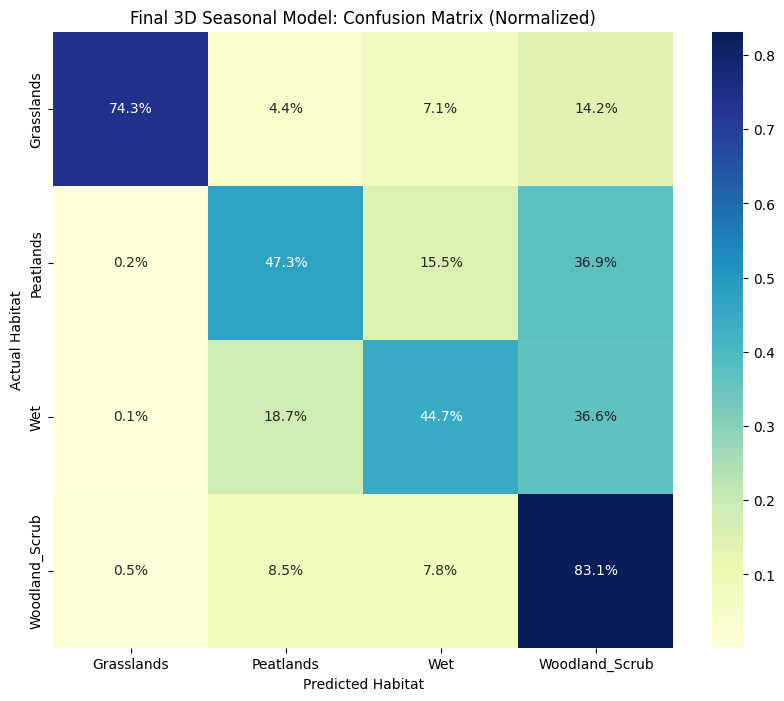

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()

In [32]:
fossitt_merger = {
    # Peatlands (P)
    'PF1': 'Peatlands',
    'PF3': 'Peatlands',
    'PF3/FS1': 'Peatlands',
    'PB4': 'Peatlands',

    # Grasslands (G)
    'GS1': 'Grasslands',

    # Woodland & Scrub (W)
    'WS1': 'Woodland_Scrub',
    'WN6': 'Woodland_Scrub',
    'WN7': 'Woodland_Scrub',
    'HH3': 'Woodland_Scrub',

    #wet
    'FS1': 'Peatlands',
    'FS2': 'Peatlands',
    'FL3': 'Peatlands',
}

gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [33]:
all_pixels, all_labels = [], []

# Using only Summer paths since Winter data is unavailable
with rasterio.open(S_RGB_PATH) as sr, \
     rasterio.open(S_NDVI_PATH) as sn, \
     rasterio.open(S_DSM) as sd:

    RES = sd.res[0]
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)

    # Map the labels (Using your column name 'FossittCod' from previous cells)
    gdf['merged_name'] = gdf['HCH_MAPPED'].replace(fossitt_merger)

    print("Extracting 16 Features (Summer Spectral + Height + Slope + Advanced Indices)...")

    for idx, row in gdf.iterrows():
        # Get random points within the polygon
        pts = get_random_points(row.geometry, 300)
        if not pts: continue

        # 1. Base Sampling (Summer Only)
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()

        # 2. Slope Sampling
        s_slopes = []
        for pt in pts:
            r_idx, c_idx = sd.index(pt[0], pt[1])
            # Define a 3x3 window around the point
            win = rasterio.windows.Window(c_idx - 1, r_idx - 1, 3, 3)
            s_win = sd.read(1, window=win, boundless=True, fill_value=0)
            s_slopes.append(calculate_local_slope(s_win, RES))

        # 3. Safe NIR Back-calculation
        # NDVI = (NIR - R) / (NIR + R) -> NIR = R * (1 + NDVI) / (1 - NDVI)
        s_nd_safe = np.clip(s_nd, -0.99, 0.99)
        s_nir = s_rgb[:, 0] * (1 + s_nd_safe) / (1 - s_nd_safe + 1e-5)

        # 4. Advanced Indices Calculation
        def calc_indices(r, g, b, nir):
            eps = 1e-5
            rvi = nir / (r + eps)
            savi = ((nir - r) / (nir + r + 0.5 + eps)) * 1.5
            evi = 2.5 * ((nir - r) / (nir + 6 * r - 7.5 * b + 1 + eps))
            gndvi = (nir - g) / (nir + g + eps)
            grvi = (g - r) / (g + r + eps)
            nrvi = (rvi - 1) / (rvi + 1 + eps)
            ndwi = (g - nir) / (g + nir + eps)
            vari = (g - r) / (g + r - b + eps)
            return np.column_stack([rvi, savi, evi, gndvi, grvi, nrvi, ndwi, vari])

        s_idx_stack = calc_indices(s_rgb[:,0], s_rgb[:,1], s_rgb[:,2], s_nir)

        # 5. Final Assembly (14 Features Total)
        combined = np.column_stack([
            s_rgb,              # 1-3: RGB
            s_nd,               # 4: NDVI
            s_h,                # 5: DSM Height
            s_nir,              # 6: Calculated NIR
            s_idx_stack,        # 7-14: (RVI, SAVI, EVI, GNDVI, GRVI, NRVI, NDWI, VARI)
            s_slopes            # 15: Local Slope
        ])

        # Mask out background/null pixels (where RGB is all 0)
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]

        if valid_pixels.shape[0] > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * valid_pixels.shape[0])

# Stack and Clean for Random Forest
X = np.vstack(all_pixels)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.array(all_labels)

print(f"Extraction Complete: X shape is {X.shape}")

Extracting 16 Features (Summer Spectral + Height + Slope + Advanced Indices)...
Extraction Complete: X shape is (12229, 15)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [35]:
rf = RandomForestClassifier(n_estimators=700, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=700, n_jobs=-1,
                       random_state=42)

In [36]:
y_pred = rf.predict(X_test)
print("\n--- FINAL 16-FEATURE REPORT ---")
print(classification_report(y_test, y_pred))


--- FINAL 16-FEATURE REPORT ---
                precision    recall  f1-score   support

    Grasslands       0.88      0.81      0.84       122
     Peatlands       0.74      0.76      0.75      1661
Woodland_Scrub       0.79      0.77      0.78      1886

      accuracy                           0.77      3669
     macro avg       0.80      0.78      0.79      3669
  weighted avg       0.77      0.77      0.77      3669



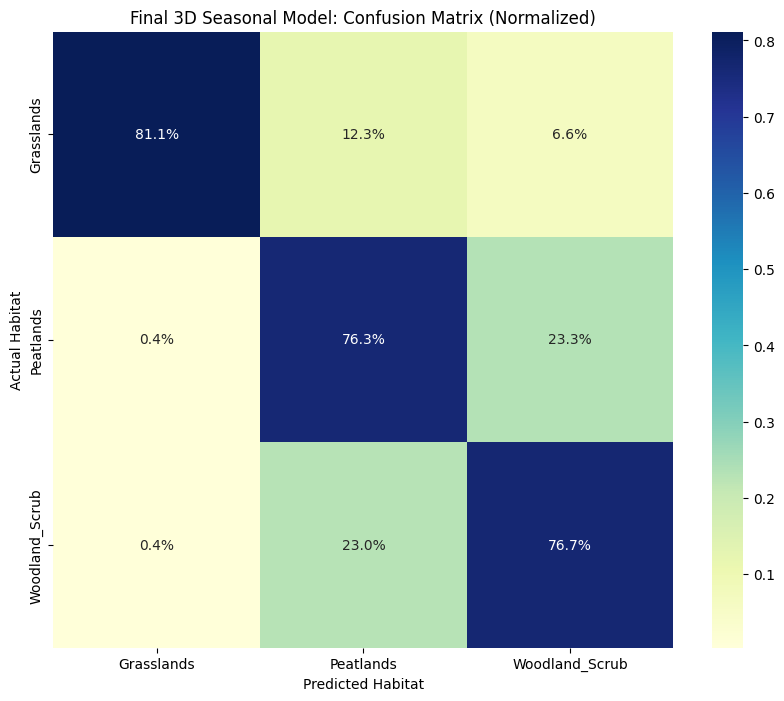

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Get the unique classes from your cleaned y_test to ensure labels match
# This prevents errors if some rare classes were merged out
labels = np.unique(y_test)

# 2. Generate the predictions
y_pred = rf.predict(X_test)

# 3. Create the matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# 4. Convert to percentages (Normalized)
# We add a tiny epsilon (1e-9) to avoid division by zero if a class is empty
cm_percent = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)

# 5. Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1%', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title('Final 3D Seasonal Model: Confusion Matrix (Normalized)')
plt.xlabel('Predicted Habitat')
plt.ylabel('Actual Habitat')
plt.show()